In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import json
from panopticapi.utils import rgb2id

BATCH_SIZE = 4
IMG_WIDTH = 128
IMG_HEIGHT = 128

TRAIN_PATH = './data/leftImg8bit_trainvaltest/leftImg8bit/train'
TEST_PATH = './data/leftImg8bit_trainvaltest/leftImg8bit/val'
TRAIN_LABELS = './data/gtFine_trainvaltest/gtFine/train'
TEST_LABELS = './data/gtFine_trainvaltest/gtFine/val'


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [2]:
print("TRAIN_PATH exists:", os.path.exists(TRAIN_PATH))
print(os.listdir(TRAIN_PATH))
print("TEST_PATH exists:", os.path.exists(TEST_PATH))
print("TRAIN_LABELS exists:", os.path.exists(TRAIN_LABELS))
print("TEST_LABELS exists:", os.path.exists(TEST_LABELS))

TRAIN_PATH exists: True
['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
TEST_PATH exists: True
TRAIN_LABELS exists: True
TEST_LABELS exists: True


In [3]:
from collections import namedtuple

#Source of this code:  https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )



labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


id2trainId = {}
for lbl in labels:
    # lbl.id is the raw labelId in 0..33 (or -1 in case of license plate).
    # lbl.trainId is the "trainId" in 0..18 or 255.
    if lbl.id >= 0:  # some entries have -1 for license plate
        id2trainId[lbl.id] = lbl.trainId
print("The Corrected id for train set:",id2trainId)


def map_cityscapes_ids_to_train_ids(label, id2trainId):
    """
    label_np: 2D NumPy array of shape [H, W], each pixel in 0..33 or 255
    id2trainId: dict mapping raw labelID -> trainID (0..18 or 255)
    returns a new array with values in [0..18] or 255
    """
    # We'll copy so we don't modify label_np in-place
    mapped = np.zeros_like(label, dtype=np.uint8)

    # For each possible 'old_id' in the dictionary, set those pixels to the new 'trainId'
    for old_id, train_id in id2trainId.items():
        mapped[label == old_id] = train_id

    # If there are any label IDs not in id2trainId, you can either keep them as is, or set them to 255
    # mapped[~np.isin(label_np, list(id2trainId.keys()))] = 255

    return mapped

The Corrected id for train set: {0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255, 7: 0, 8: 1, 9: 255, 10: 255, 11: 2, 12: 3, 13: 4, 14: 255, 15: 255, 16: 255, 17: 5, 18: 255, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 29: 255, 30: 255, 31: 16, 32: 17, 33: 18}


In [4]:


class CityscapesDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None, img_size=(128, 128)):

        """ 
        :param images_dir:  path to Cityscapes leftImg8bit FOLDER (e.g. ".../leftImg8bit/train")
        :param labels_dir:  path to Cityscapes gtFine FOLDER (e.g. ".../gtFine/train")
        :param transforms:  optional data augmentations / transformations
        :param img_size:    (width, height) to which we will resize all images & labels, default!!!
        """
          
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.img_width, self.img_height = img_size
        self.id2trainId = id2trainId
        
        self.image_files= [] #gather all image filnames under the 'images_dir'(raw images, for leftrImg8bit)
        for city in os.listdir(self.images_dir): #Loop through each subfolder of each city
            city_folder = os.path.join(self.images_dir, city) #Full Path
            if os.path.isdir(city_folder): #check if it's a directory but not a file
                for fname in os.listdir(city_folder): #loop through all files in that city folder 
                    if fname.endswith('_leftImg8bit.png'):
                        self.image_files.append((city,fname)) #Store in a tuple so we can reconstruct paths later
        self.image_files.sort() #Sort so that the dataset order is consistnet each time
        """
        Q: Why Sort the File?????
        Ans: If you never sort, the order might differ run to run (or machine to machine), because Python’s os.listdir()
        does not guarantee a fixed ordering, it's intentional to produce a stable sequence
        """

    def __len__(self): #Returns the number of images in the leftImg8bit
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Given an index idx, rerturn the pair as tensors
        """
        city, img_name = self.image_files[idx]

        #1 Load the RGB images
        #Build the FULL path to the image in leftImg8bit
        img_path = os.path.join(self.images_dir, city, img_name)
        # Use OpenCV to read in color (BGR, blue green red) mode
        img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if img_bgr is None:
            raise FileNotFoundError(f"BRO, Sadly no images founded at this link: {img_path}") #Note that img_path is Full Path

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #Convert BGR to RGB

        #2. Find the corresponding label filename:
        label_name  =img_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')

        #Build the full path to the label in the Lables_dir
        label_path = os.path.join(self.labels_dir,city,label_name)

        #Load raw label as Numpy Array where each pixel has raw integer ID
        label = cv2.imread(label_path,cv2.IMREAD_UNCHANGED) 
        if label is None:
            raise FileNotFoundError(f"Could not find label file: {label_path}")
        # 1) Map from labelId -> trainId
        label = map_cityscapes_ids_to_train_ids(label, self.id2trainId)



        #3. Resize both the image and the label to what we defined, 128 * 128
        #    - We use INTER_LINEAR for the image to preserve visual quality.
        #    - We use INTER_NEAREST for the label to avoid interpolating class IDs.
        img_rgb = cv2.resize(img_rgb, (self.img_width, self.img_height), interpolation=cv2.INTER_LINEAR)
        label = cv2.resize(label, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)


        #4. Convert the numpy array to PyTorch Tensors
        #    - permute(2,0,1) changes shape from (H,W,C) to (C,H,W).
        #    - .float() ensures image has floating-point type.
        #Converts PyTorch tensor to int64 long integer format
                                                        #Which is needed for Classification Labels(CrossEntropyLoss)
        img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float()
        label_tensor = torch.from_numpy(label).long()
        if self.transforms is not None:
            img_tensor = self.transforms(img_tensor)

        return img_tensor, label_tensor 

In [5]:
train_dataset = CityscapesDataset(
    images_dir= TRAIN_PATH,         
    labels_dir=TRAIN_LABELS,         
    transforms= None,
    img_size=(IMG_HEIGHT, IMG_WIDTH) # e.g. (128, 128)
)

val_dataset = CityscapesDataset(
    images_dir=TEST_PATH,           # e.g. "./cityscapes/data/leftImg8bit_trainvaltest/leftImg8bit/val"
    labels_dir=TEST_LABELS,           # e.g. "./cityscapes/data/gtFine_trainvaltest/gtFine/val"
    transforms=None,
    img_size=(IMG_HEIGHT, IMG_WIDTH) #(128,128)
)

#train_loader is a PyTorch DataLoader object that wraps your training dataset (e.g., train_dataset) so you can iterate
# over the data in minibatches for later use.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np


def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    # ^ Picks a random index between 0 and len(dataset)-1.

    image, mask = dataset[idx]
    # ^ Retrieves the (image, mask) pair from the dataset.

    if isinstance(image, torch.Tensor): #In short, PyTorch Tensor wants [C,H,W] but displaying tool like matlabplot wants
                                        #[H,W,C], so we convert it to display purpose
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = np.clip(image_np, 0, 255).astype(np.uint8)
        """
        Below is an error!!!! Remember I convert pytorch tensor to float before? 
        matplotlib expects that:

        If your image array is an integer type (uint8), the valid range is [0..255].
        If your image array is a float type, the valid range is [0..1].
        现在tensor是float但是却in range 0 to 255，2种解决办法
        """
        #if image_np.max() <= 1.0: # If pixel values are in [0,1], scale them to [0,255] for proper plotting.
            #image_np = (image_np * 255).astype(np.uint8)
    else:
        # If the dataset returned a NumPy array, just rename it image_np.
        image_np = image
        
    # Plot the image on the left
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)   # Show the image in RGB format
    plt.title("Image")

    # Plot the segmentation mask on the right
    plt.subplot(1, 2, 2)
    # If 'mask' is a tensor, move it to CPU and make a NumPy array
    plt.imshow(mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask)
    plt.title("Mask")

    plt.show()


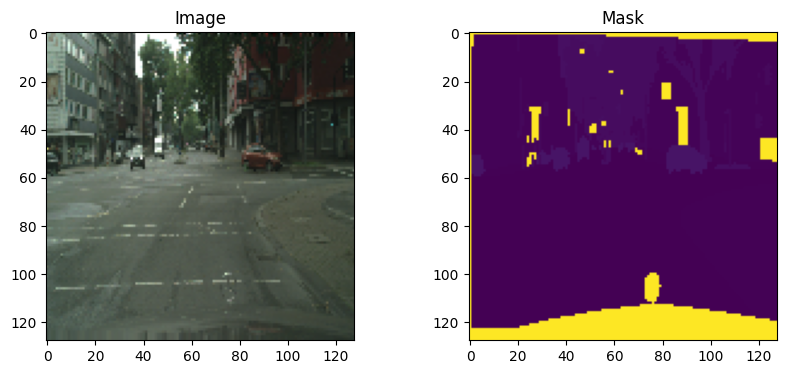

In [7]:
visualize_random_sample(train_dataset)

In [8]:
def mean_iou(y_pred, y_true, num_classes, smooth=1e-6):
    
    y_pred = torch.softmax(y_pred/0.5, dim=1)
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []

    for class_id in range(num_classes):
        intersection = torch.sum((y_pred == class_id) & (y_true == class_id))
        union = torch.sum((y_pred == class_id) | (y_true == class_id))
        
        if union == 0:
            continue 
        
        iou = (intersection.float() + smooth) / (union.float() + smooth)
        iou_list.append(iou)


    return torch.mean(torch.stack(iou_list))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Mask2FormerAttention(nn.Module):
    def __init__(self, channels, size):
        super(Mask2FormerAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)
        self.mask = None  
        self.norm = nn.LayerNorm([channels])

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        if channels != self.channels:
            raise ValueError("Input channel size does not match initialized channel size.")
        
        x = x.view(batch_size, channels, height * width).permute(0, 2, 1)  

        Q = self.query(x)  
        K = self.key(x)    
        V = self.value(x)  

        scores = torch.matmul(Q, K.transpose(-2, -1))  
        scores = scores / (self.channels ** 0.5)       

        if self.mask is None or self.mask.size(-1) != height * width:
            binary_mask = torch.randint(0, 2, (batch_size, height, width), device=x.device)
            binary_mask = binary_mask.view(batch_size, -1)  
            processed_mask = torch.where(binary_mask > 0.5, torch.tensor(0.0, device=x.device), torch.tensor(-float('inf'), device=x.device))
            self.mask = processed_mask.unsqueeze(1).expand(-1, height * width, -1) 
            
        scores = scores + self.mask

        attention_weights = F.softmax(scores, dim=-1)  
        attention_output = torch.matmul(attention_weights, V) 
        attention_output = attention_output + x  
        attention_output = self.norm(attention_output)
        
        return attention_output.view(batch_size, channels, height, width)


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
            nn.BatchNorm2d(out_channels)
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
            nn.BatchNorm2d(out_channels)
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x
    
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = Mask2FormerAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = Mask2FormerAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = Mask2FormerAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)
        
        self.dropout = nn.Dropout(0.3)
        
        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = Mask2FormerAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = Mask2FormerAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = Mask2FormerAttention(64, 64)
        self.norm = nn.LayerNorm([64, 128, 128])
        # self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)
        self.final_layer = nn.Sequential(
                                nn.Conv2d(64, c_out, kernel_size=1),
                                nn.BatchNorm2d(c_out), 
                                nn.ReLU()  
                            )

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        x = self.dropout(x)
        x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        x = self.dropout(x)
        x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        x = self.self_attention6(x)
        x = self.norm(x)
        # output = self.output_conv(x)
        output = self.final_layer(x)
        return output

#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')

In [11]:
import torch.backends.cudnn as cudnn
from torch_lr_finder import LRFinder

c_in = 3  # input channel 3 for RGB
c_out = 19 #Do some research online~

model = UNet(c_in, c_out)
checkpoint_path = "../checkpoint/checkpoint.pth"
print("TRAIN_PATH exists:", os.path.exists(checkpoint_path))
# for module in model.modules():
#     if hasattr(module, "mask"):
#         module.mask = None
#print(os.path.exists(checkpoint_path))

#GPU usage:
device_count = torch.cuda.device_count()
if device_count == 0:
    raise RuntimeError("No GPU found! Training on CPU.")
elif device_count == 1:
    print("Using single GPU mode.")
    device = torch.device("cuda:0")
    model.to(device)
else:
    print(f"Using {device_count} GPUs")
    device = torch.device("cuda:0")
    model = torch.nn.DataParallel(model)
    model.to(device)


#Loading checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model_dict = model.state_dict()#For current model's State dictionary, Every PyTorch module has a one mapping layer names → parameters.
pretrained_dict = {} # We will store only the checkpoint's layers that MATCH our current model's shape

for k, v in checkpoint.items():
    # Only load layers that match both the name and shape
    if k in model_dict and v.shape == model_dict[k].shape:
        pretrained_dict[k] = v
    else:
        print(f"Skipping layer {k} due to shape mismatch: {v.shape} != {model_dict.get(k, None)}")

model_dict.update(pretrained_dict) # Update the model's state dict with filtered, matched weights 
model.load_state_dict(model_dict, strict = False)  # Finally, load that updated dictionary into the model.
for module in model.modules():
    if hasattr(module, "mask"):
        module.mask = None

cudnn.benchmark = True

#Loss, optimizer...

#print(torch.unique(labels))
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=5e-4, 
    steps_per_epoch=len(train_loader),
    epochs=400
)
early_stopping = EarlyStopping(patience=10, verbose=True)

c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


TRAIN_PATH exists: True
Using single GPU mode.
Skipping layer module.initial_conv.conv_block.0.weight due to shape mismatch: torch.Size([64, 3, 3, 3]) != None
Skipping layer module.initial_conv.conv_block.1.weight due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.1.bias due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.1.running_mean due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.1.running_var due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.1.num_batches_tracked due to shape mismatch: torch.Size([]) != None
Skipping layer module.initial_conv.conv_block.3.weight due to shape mismatch: torch.Size([64, 64, 3, 3]) != None
Skipping layer module.initial_conv.conv_block.4.weight due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.4.bias due to shape mismatch: torch.Size([64

In [12]:
for i, (inputs, labels) in enumerate(train_loader):
    unique_vals = labels.unique()
    print("Unique labels in this batch:", unique_vals)
    break  # just break after the first batch for debugging

#Clear Memory

torch.cuda.empty_cache()


Unique labels in this batch: tensor([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  16,
         17,  18, 255])


In [ ]:
# Training loop
from torch.amp import autocast,GradScaler

num_epochs = 500
best_loss = float("inf")
best_iou = 0.0

log_file = open("training_log_backend.txt", "w")

# Create the GradScaler once (for AMP).
scaler = torch.amp.GradScaler()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # -- Mixed precision forward pass --
        with torch.amp.autocast(device_type = "cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # -- Backward with scaled loss --
        scaler.scale(loss).backward()

        # -- Step optimizer with scaled gradients --
        scaler.step(optimizer)
        scaler.update()

        # -- Compute IoU, etc. --
        iou = mean_iou(outputs, labels, c_out)

        total_loss += loss.item()
        total_iou += iou.item()

        # Checkpoints in the middle of an epoch if you want
        if i % 500 == 0 and i != 0:
            avg_so_far_loss = total_loss / (i+1)
            avg_so_far_iou  = total_iou / (i+1)
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] "
                  f"Loss: {avg_so_far_loss:.4f} IoU: {avg_so_far_iou:.4f}")
            if i % 200 == 0:
                print("Saving intermediate model checkpoint...")
                torch.save(model.state_dict(), 'checkpoint_intermediate.pth')

    # End of epoch metrics
    avg_loss = total_loss / len(train_loader)
    avg_iou  = total_iou  / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")

    best_loss = min(best_loss, avg_loss)
    best_iou  = max(best_iou,  avg_iou)

    # Overfit detection? (custom logic)
    if best_iou - avg_iou > 0.1:
        print("Model Overfitting: difference in best_iou vs. current_iou > 0.1.")
        break

    # Step the scheduler
    scheduler.step()

    # Save epoch checkpoint
    torch.save(model.state_dict(), 'epoch_latest.pth')

    # Log to file
    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} IoU: {avg_iou:.4f}\n")
    log_file.write(f"Best loss: {best_loss:.4f}, Best IoU: {best_iou:.4f}\n\n")
    log_file.flush()

    # Early stopping
    if early_stopping(avg_loss, model):
        print("Early stopping triggered!")
        break

log_file.close()
print(f"Best loss = {best_loss:.4f}, best iou = {best_iou:.4f}")

 12%|█▏        | 90/744 [13:26<1:33:26,  8.57s/it]

In [ ]:
model = model.to(device)
best_val_loss = float("inf")
best_val_iou = 0.0
log_file = open("validating_log_trail2.txt", "w")
for epoch in range(0,num_epochs):
    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            # inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_val_iou += mean_iou(outputs, labels,c_out).item()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    preds_val = outputs

    avg_val_loss = total_val_loss / num_batches
    avg_val_iou = total_val_iou / num_batches

    print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")
    
    best_val_loss = min(best_val_loss,avg_val_loss)
    best_val_iou = max(best_val_iou,avg_val_iou)
    
    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_val_loss} IoU: {avg_val_iou}\n")
    log_file.write(f'Best loss: {best_val_loss}, Best IoU: {best_val_iou}\n\n')
    log_file.flush()

print(f'Best Validation loss is {best_val_loss}, best Validation iou is {best_val_iou}')
log_file.close()

100%|██████████| 625/625 [03:04<00:00,  3.38it/s]


Validation Loss: 4.136365626144409, Validation IoU: 0.017687656047940255


 17%|█▋        | 105/625 [00:30<02:33,  3.40it/s]


KeyboardInterrupt: 

In [62]:
def visualize_predictions(model, dataset, device, idx=0):
    model.eval()
    with torch.no_grad():
        image, mask = dataset[idx] 
        image = image.unsqueeze(0).to(device)  
        
        output = model(image)
        print(output.shape)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")

        plt.show()


torch.Size([1, 133, 128, 128])


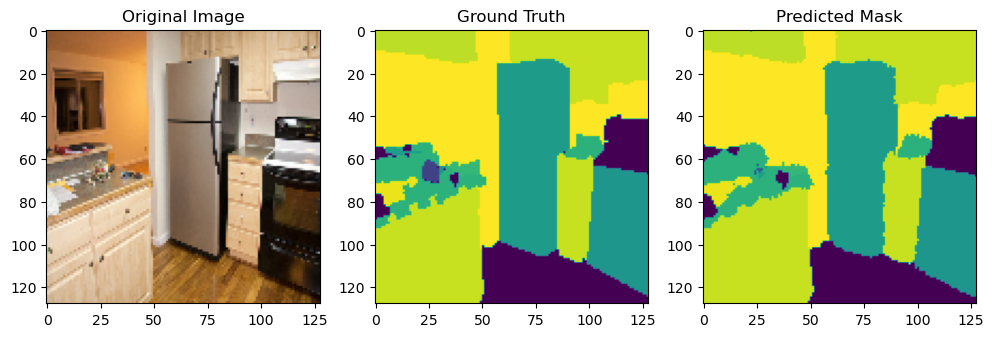

In [ ]:
test_idx = random.randint(0, len(train_dataset) - 1)
visualize_predictions(model, train_dataset, device, idx=test_idx)